In [104]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

#### Loading Data and Data Augmentations

In [210]:
data_augmentations = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomResizedCrop((64,64),),
        transforms.RandomPerspective(),
        transforms.RandomRotation(24),
        transforms.ToTensor(),
        transforms.RandomErasing(0.4),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

data_normalizations = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

full_ds = datasets.ImageFolder(root="./data/train")

#### Check if dataset is unbalance

In [221]:
import os

class_numbers = []
for name in os.listdir('./data/train'):
    class_numbers.append(len([name for name in os.listdir('./data/train/'+name)]))

cls_num = set(class_numbers)
class_num_dict = {num: 1 for num in cls_num}
for num in class_numbers:
    class_num_dict[num] +=1
class_num_dict

{1800: 49, 1108: 2, 503: 2}

Dataset seems to be balanced enough

#### Lets see some images

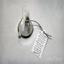

In [108]:
full_ds[0][0]

#### Number of different classes

In [109]:
len(os.listdir('./data/train'))

50

#### Making dataloaders for model

In [212]:
BATCH = 128

train_len = int(len(full_ds) * 0.7)
validation_len = int(len(full_ds) * 0.15)
# test_len = len(full_ds) - train_len - validation_len
# train_ds, valid_ds, test_ds = data.random_split(dataset=full_ds, lengths=[train_len, validation_len, test_len], generator=torch.Generator().manual_seed(42))

train_ds = datasets.ImageFolder(root="./data/train", transform=data_augmentations)
valid_ds = datasets.ImageFolder(root="./data/train", transform=data_normalizations)
test_ds = datasets.ImageFolder(root="./data/train", transform=data_normalizations)

indices = torch.randperm(len(train_ds), generator=torch.Generator().manual_seed(42))
train_ds = data.Subset(train_ds, indices[:train_len])
valid_ds = data.Subset(valid_ds, indices[train_len:train_len+validation_len])
test_ds = data.Subset(test_ds, indices[train_len+validation_len:])

train_dl  = data.DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=True, pin_memory=True)
valid_dl  = data.DataLoader(valid_ds, batch_size=BATCH, pin_memory=True)
test_dl  = data.DataLoader(test_ds, batch_size=BATCH, pin_memory=True)


#### Model Definition

In [207]:
class SimpleCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        CHANNELS = [16, 32, 32, 32, 256, 256, 512, 512, 512]
        KERNELS = [7, 5, 5, 5, 3, 3, 3, 3, 3]
        LINEARS = [512, 256, 50]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=CHANNELS[0], kernel_size=KERNELS[0], padding=3, padding_mode="zeros", stride=2)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(CHANNELS[0])

        self.conv2 = nn.Conv2d(in_channels=CHANNELS[0], out_channels=CHANNELS[1], kernel_size=KERNELS[1], padding=2, padding_mode="zeros")
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(CHANNELS[1])

        self.conv3 = nn.Conv2d(in_channels=CHANNELS[1], out_channels=CHANNELS[2], kernel_size=KERNELS[2], padding=2, padding_mode="zeros")
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(CHANNELS[2])

        self.conv4 = nn.Conv2d(in_channels=CHANNELS[2]+CHANNELS[1], out_channels=CHANNELS[3], kernel_size=KERNELS[3], padding=2, padding_mode="zeros", stride=2)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(CHANNELS[3])

        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = nn.Conv2d(in_channels=CHANNELS[3], out_channels=CHANNELS[4], kernel_size=KERNELS[4], padding=1, padding_mode="zeros")
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm2d(CHANNELS[4])

        self.conv6 = nn.Conv2d(in_channels=CHANNELS[4], out_channels=CHANNELS[5], kernel_size=KERNELS[5], padding=1, padding_mode="zeros")
        self.relu6 = nn.ReLU()
        self.bn6 = nn.BatchNorm2d(CHANNELS[5])


        self.conv7 = nn.Conv2d(in_channels=CHANNELS[5]+CHANNELS[4], out_channels=CHANNELS[6], kernel_size=KERNELS[6], padding=1, padding_mode="zeros")
        self.relu7 = nn.ReLU()
        self.bn7 = nn.BatchNorm2d(CHANNELS[6])

        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        self.conv8 = nn.Conv2d(in_channels=CHANNELS[6], out_channels=CHANNELS[7], kernel_size=KERNELS[7], padding=1, padding_mode="zeros", stride=2)
        self.relu8 = nn.ReLU()
        self.bn8 = nn.BatchNorm2d(CHANNELS[7])

        self.conv9 = nn.Conv2d(in_channels=CHANNELS[7], out_channels=CHANNELS[8], kernel_size=KERNELS[8], padding=1, padding_mode="zeros", stride=2)
        self.relu9 = nn.ReLU()
        self.bn9 = nn.BatchNorm2d(CHANNELS[8])

        self.flatten = nn.Flatten()
        self.d1 = nn.Linear(in_features=LINEARS[0], out_features=LINEARS[1])
        self.relu10 = nn.ReLU()
        self.bn10 = nn.BatchNorm1d(LINEARS[1])
        self.dropout = nn.Dropout(0.65)
        self.d2 = nn.Linear(in_features=LINEARS[1], out_features=LINEARS[2])

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.bn1(y)

        res1 = self.conv2(y)
        y = self.relu2(res1)
        y = self.bn2(y)


        y = self.conv3(y)
        y = self.relu3(y)
        y = self.bn3(y)

        y = torch.concat([y, res1], dim=1)
        y = self.conv4(y)
        y = self.relu4(y)
        y = self.bn4(y)

        y = self.maxpool2(y)

        res2 = self.conv5(y)
        y = self.relu5(res2)
        y = self.bn5(y)

        y = self.conv6(y)
        y = self.relu6(y)
        y = self.bn6(y)

        y = torch.concat([y, res2], dim=1)
        y = self.conv7(y)
        y = self.relu7(y)
        y = self.bn7(y)

        y = self.maxpool3(y)
        
        y = self.conv8(y)
        y = self.relu8(y)
        y = self.bn8(y)

        y = self.conv9(y)
        y = self.relu9(y)
        y = self.bn9(y)

        y = self.flatten(y)

        y = self.d1(y)
        y = self.relu10(y)
        y = self.bn10(y)
        y = self.dropout(y)

        y = self.d2(y)
        return y

#### Trainer

In [208]:
from typing import Callable

class Trainer:
    """
    Class responsible for training the model
    """

    def __init__(
            self,
            model: nn.Module,
            optim: torch.optim.Optimizer,
            loss: Callable,
            train_dataloader: data.DataLoader,
            valid_dataloader: data.DataLoader,
            test_dataloader: data.DataLoader,
            metric: Callable,
            verbose: bool = True
        ):
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.model = model.to(self.device)
        self.optim = optim
        self.loss = loss
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.test_dataloader = test_dataloader
        self.metric = metric
        self.verbose = verbose
        self.history: list[tuple[float, float, float, float]] = []


    def evaluate(self, eval_dataloader: data.DataLoader) -> float:
        """
        Evaluates the model on given dataset
        """
        losses = []
        metric_scores = []
        self.model.eval()
        with torch.no_grad():
            for imgs, labels in eval_dataloader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)
                
                predictions = self.model(imgs.float()).squeeze(dim=1)

                loss = self.loss(predictions, labels)
                losses.append(loss.item())
                metric_scores.append(self.metric(predictions, labels))
        return sum(losses) / len(losses), sum(metric_scores) / len(metric_scores)

    
    def train_one_epoch(self) -> None:
        """
        Trains one epoch
        """
        losses = []
        metric_scores = []
        self.model.train()
        for imgs, labels in self.train_dataloader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            predictions = self.model(imgs.float()).squeeze(dim=1)

            loss = self.loss(predictions, labels)

            self.optim.zero_grad()

            loss.backward()

            self.optim.step()

            losses.append(loss.item())
            metric_scores.append(self.metric(predictions, labels))
        self.history.append(
            (sum(losses)/len(losses), sum(metric_scores)/len(metric_scores), *self.evaluate(self.valid_dataloader))
        )
    
    def train(self, epochs: int, early_stoping: int = 0) -> None:
        """
        Trains model
        """
        min_loss = None
        without_progress = 0
        try:
            for epoch in range(epochs):
                self.train_one_epoch()
                if self.verbose is True:
                    train_loss, train_metric, valid_loss, valid_metric = self.history[-1]
                    print(
                        f"Epoch: {epoch}\t Train loss: {train_loss:.4}\t accuracy: {train_metric:.4}\t Validation loss: {valid_loss:.4}\t accuracy: {valid_metric:.4}"
                    )
                if early_stoping > 0:
                    _, _, valid_loss, _ = self.history[-1]
                    if min_loss is None:
                        min_loss = valid_loss
                    elif min_loss > valid_loss:
                        min_loss = valid_loss
                        without_progress = 0
                    else:
                        without_progress += 1
                    
                    if without_progress >= early_stoping:
                        break
        except KeyboardInterrupt:
            pass

        if self.verbose is True:
            test_loss, test_accuracy = self.evaluate(self.test_dataloader)
            print(f"Test loss: {test_loss:.4}\t accuracy: {test_accuracy:.4}")

#### Training the model

In [213]:
import torchmetrics

model = SimpleCNN()
optim = torch.optim.Adam(params=model.parameters(), lr=0.01)
loss = nn.functional.cross_entropy
metric = torchmetrics.functional.accuracy


trainer = Trainer(model=model, optim=optim, loss=loss, train_dataloader=train_dl, valid_dataloader=valid_dl, test_dataloader=test_dl, metric=metric)
trainer.train(223)

Epoch: 0	 Train loss: 3.638	 accuracy: 0.08495	 Validation loss: 3.248	 accuracy: 0.1407
Epoch: 1	 Train loss: 3.324	 accuracy: 0.1296	 Validation loss: 3.092	 accuracy: 0.1759
Epoch: 2	 Train loss: 3.241	 accuracy: 0.146	 Validation loss: 3.086	 accuracy: 0.1743
Epoch: 3	 Train loss: 3.184	 accuracy: 0.1615	 Validation loss: 2.952	 accuracy: 0.2118
Epoch: 4	 Train loss: 3.118	 accuracy: 0.1818	 Validation loss: 2.852	 accuracy: 0.23
Epoch: 5	 Train loss: 3.072	 accuracy: 0.1883	 Validation loss: 2.784	 accuracy: 0.2459
Epoch: 6	 Train loss: 3.005	 accuracy: 0.2056	 Validation loss: 2.655	 accuracy: 0.286
Epoch: 7	 Train loss: 2.969	 accuracy: 0.2141	 Validation loss: 2.592	 accuracy: 0.2932
Epoch: 8	 Train loss: 2.92	 accuracy: 0.2282	 Validation loss: 2.599	 accuracy: 0.3156
Epoch: 9	 Train loss: 2.893	 accuracy: 0.2339	 Validation loss: 3.143	 accuracy: 0.1779
Epoch: 10	 Train loss: 2.917	 accuracy: 0.2319	 Validation loss: 2.565	 accuracy: 0.3166
Epoch: 11	 Train loss: 2.825	 accur

#### Inspecting train history

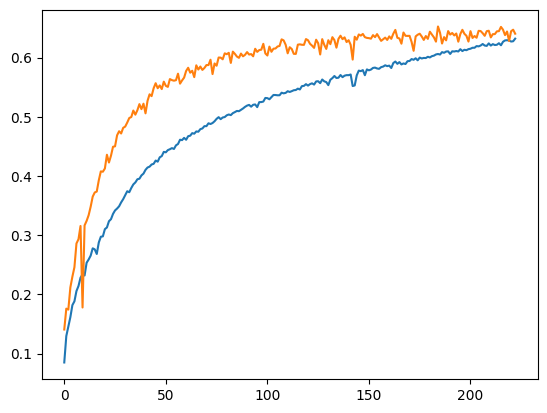

In [216]:
train_loss = [train_loss for train_loss, train_metric, valid_loss, valid_metric in trainer.history]
valid_loss = [valid_loss for train_loss, train_metric, valid_loss, valid_metric in trainer.history]
train_acc = [train_metric.cpu() for train_loss, train_metric, valid_loss, valid_metric in trainer.history]
valid_acc = [valid_metric.cpu() for train_loss, train_metric, valid_loss, valid_metric in trainer.history]

# plt.plot(range(len(train_loss)), train_loss)
# plt.plot(range(len(valid_loss)), valid_loss)
plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(valid_acc)), valid_acc)

#### Lets train a little more

In [219]:
trainer.train(50)

Epoch: 0	 Train loss: 1.363	 accuracy: 0.6289	 Validation loss: 1.847	 accuracy: 0.6474
Epoch: 1	 Train loss: 1.366	 accuracy: 0.6311	 Validation loss: 4.647	 accuracy: 0.6335
Epoch: 2	 Train loss: 1.407	 accuracy: 0.6183	 Validation loss: 6.865	 accuracy: 0.6397
Epoch: 3	 Train loss: 1.369	 accuracy: 0.6297	 Validation loss: 6.495	 accuracy: 0.6404
Epoch: 4	 Train loss: 1.354	 accuracy: 0.6311	 Validation loss: 4.47	 accuracy: 0.6396
Epoch: 5	 Train loss: 1.357	 accuracy: 0.6316	 Validation loss: 9.281	 accuracy: 0.6449
Epoch: 6	 Train loss: 1.34	 accuracy: 0.6373	 Validation loss: 3.425	 accuracy: 0.6469
Epoch: 7	 Train loss: 1.355	 accuracy: 0.6311	 Validation loss: 4.766	 accuracy: 0.6427
Epoch: 8	 Train loss: 1.365	 accuracy: 0.6309	 Validation loss: 2.275	 accuracy: 0.6451
Epoch: 9	 Train loss: 1.348	 accuracy: 0.6352	 Validation loss: 7.701	 accuracy: 0.6403
Epoch: 10	 Train loss: 1.345	 accuracy: 0.6349	 Validation loss: 5.206	 accuracy: 0.6408
Epoch: 11	 Train loss: 1.351	 acc

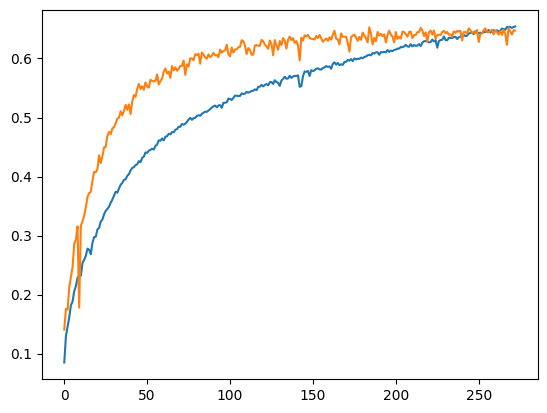

In [220]:
train_loss = [train_loss for train_loss, train_metric, valid_loss, valid_metric in trainer.history]
valid_loss = [valid_loss for train_loss, train_metric, valid_loss, valid_metric in trainer.history]
train_acc = [train_metric.cpu() for train_loss, train_metric, valid_loss, valid_metric in trainer.history]
valid_acc = [valid_metric.cpu() for train_loss, train_metric, valid_loss, valid_metric in trainer.history]

# plt.plot(range(len(train_loss)), train_loss)
# plt.plot(range(len(valid_loss)), valid_loss)
plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(valid_acc)), valid_acc)

We can see that the model is starting to overfit so it probably will not improve much from this point on 

#### Lets save the model

In [217]:
torch.save(trainer.model.state_dict(), "./true64%_222e.pth")

#### Checking if the results make sense

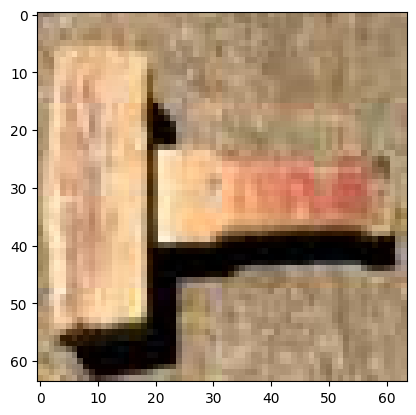

hammer


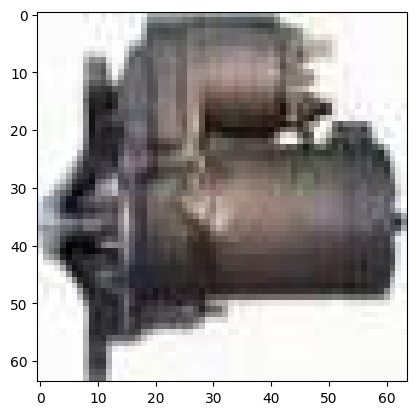

motor


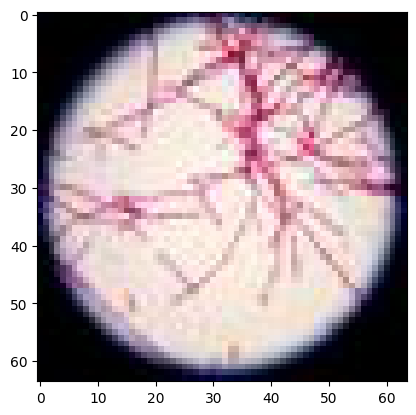

bacteria


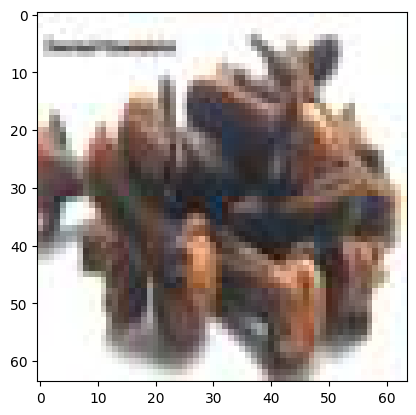

spice


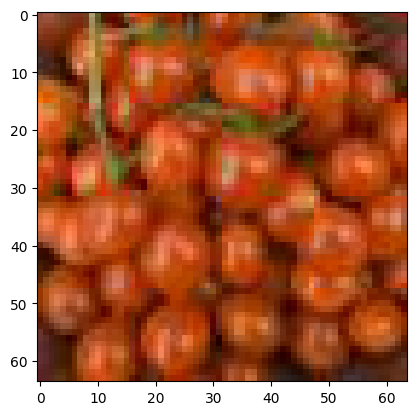

tomato


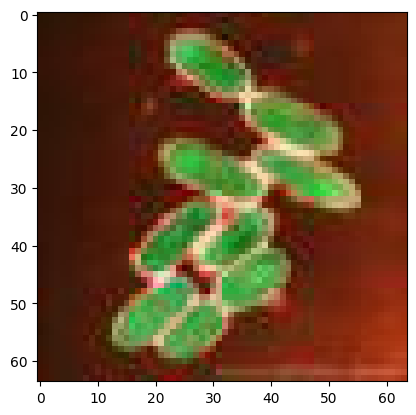

bacteria


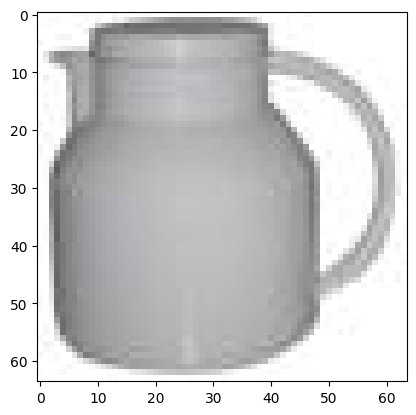

pot


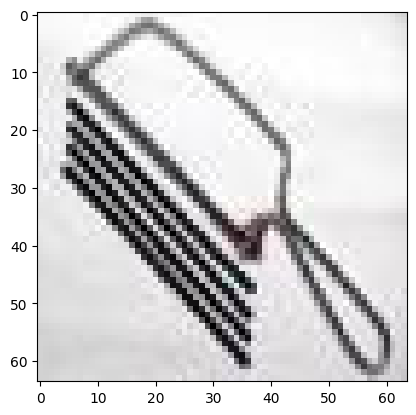

saw


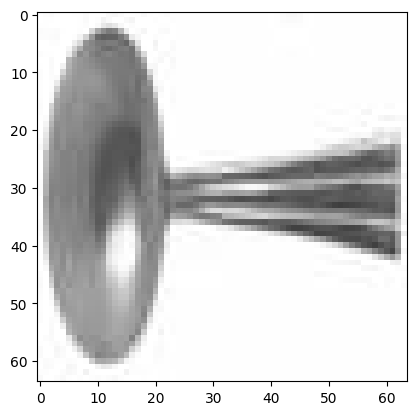

spoon


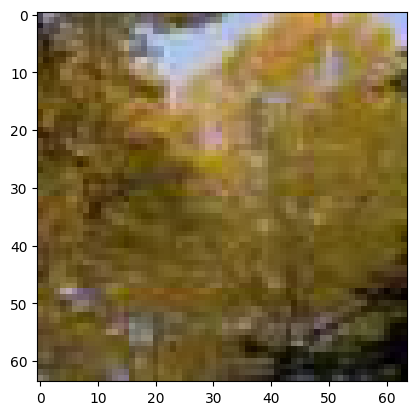

birch


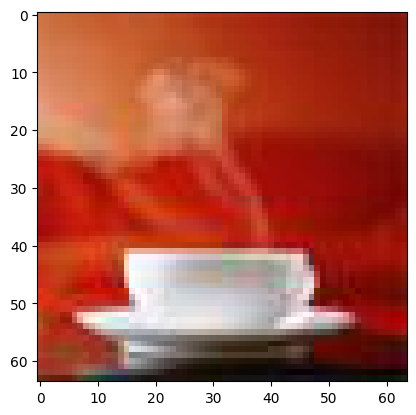

tea


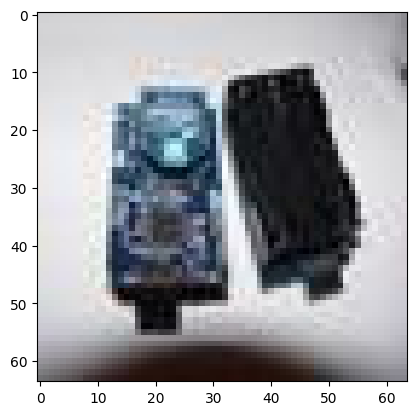

gauge


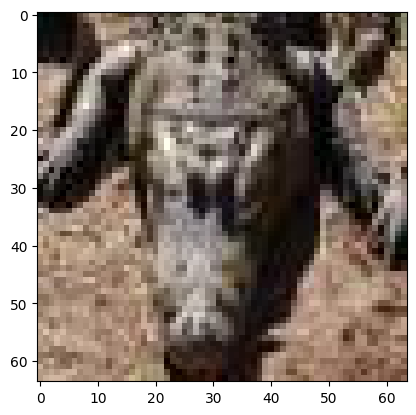

crocodilian


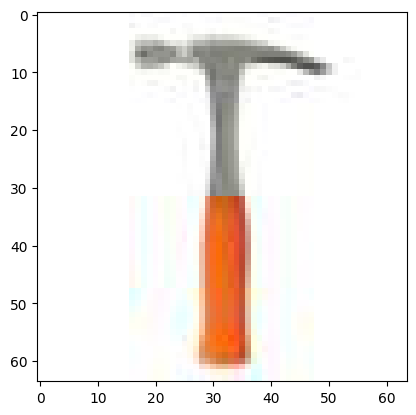

hammer


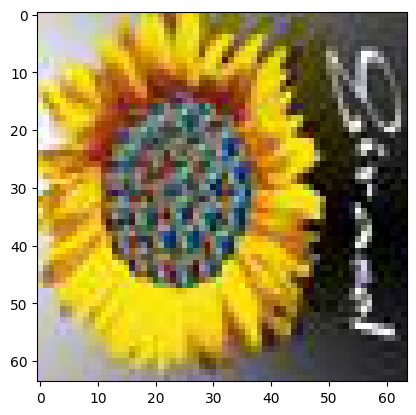

flower


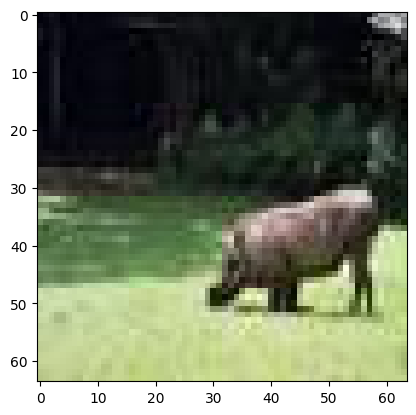

swine


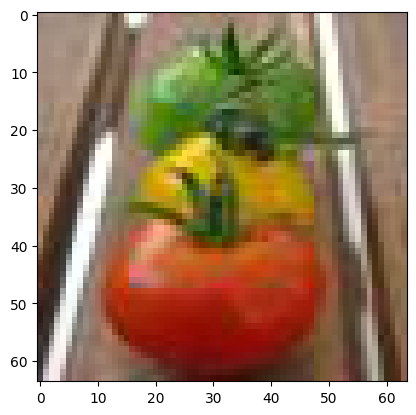

tomato


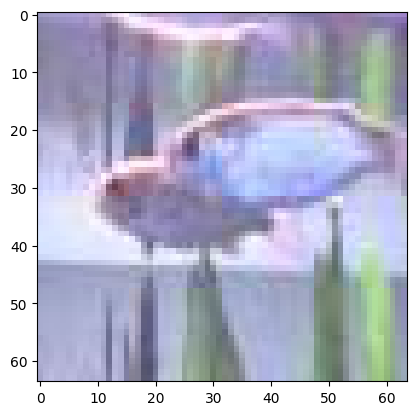

towel


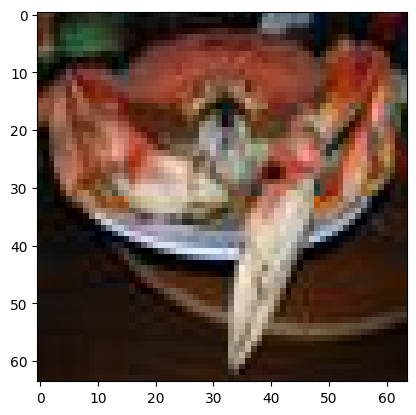

crab


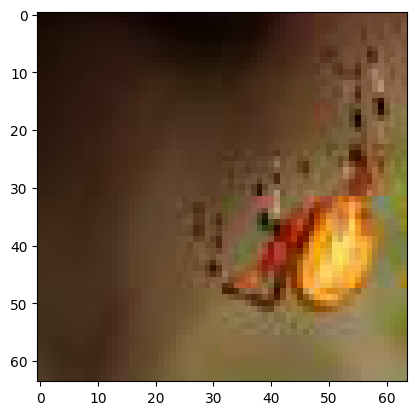

spider


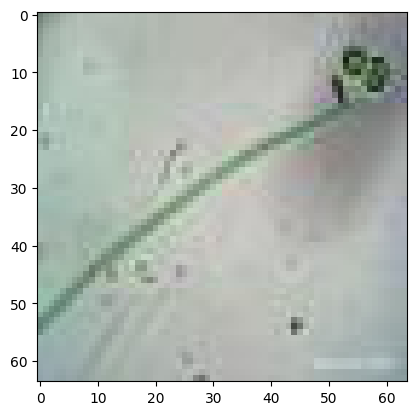

bacteria


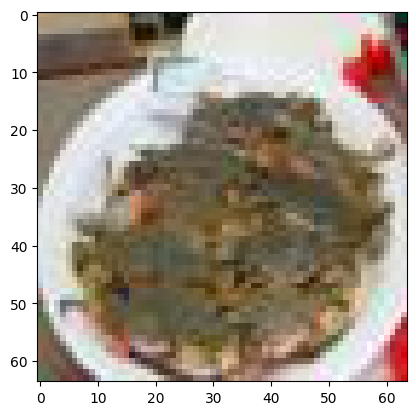

spice


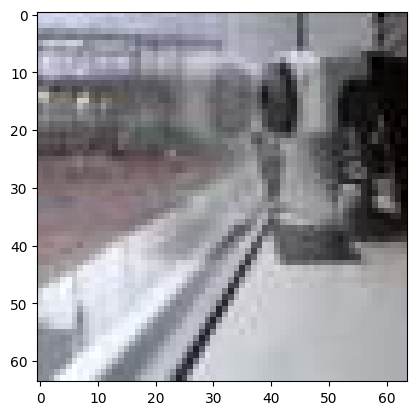

camera


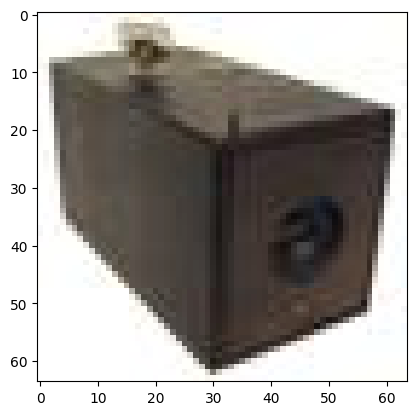

camera


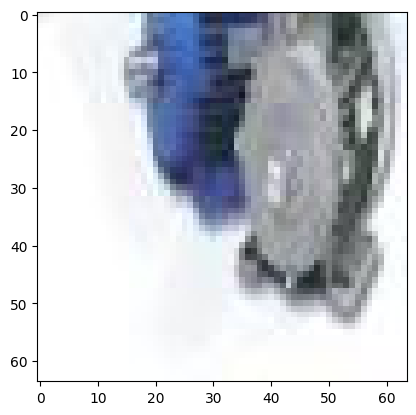

motor


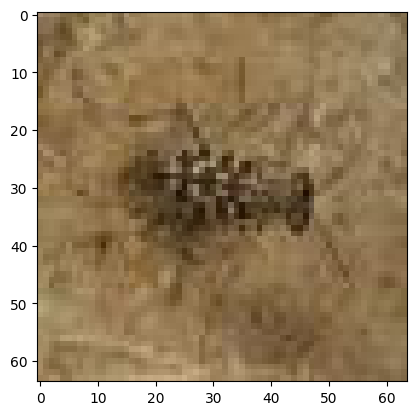

beetle


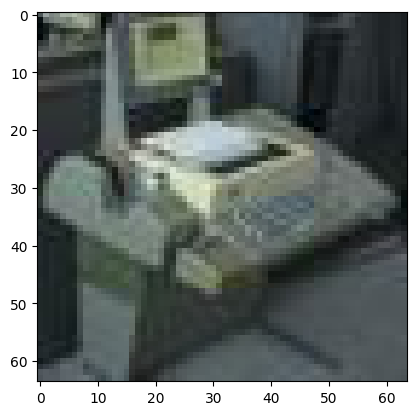

printer


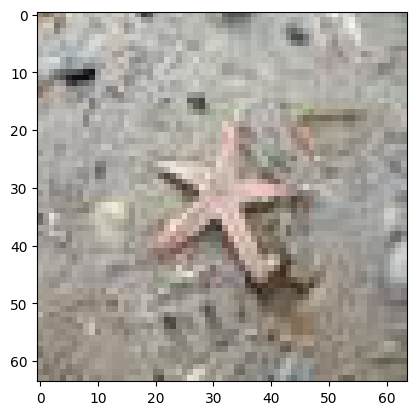

echinoderm


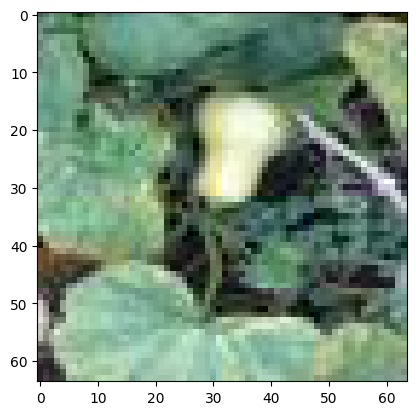

monkey


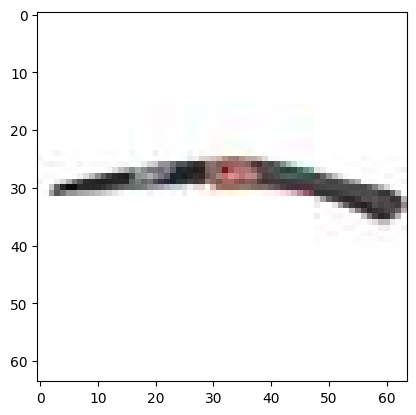

saw


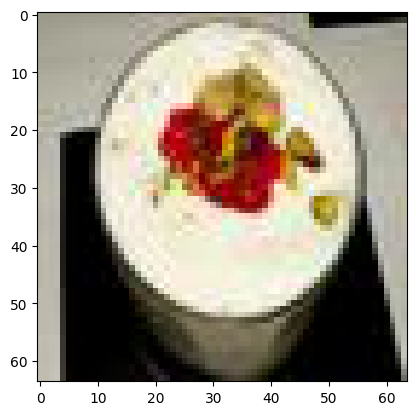

icecream


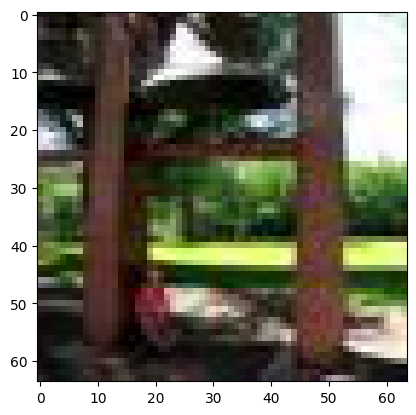

truck


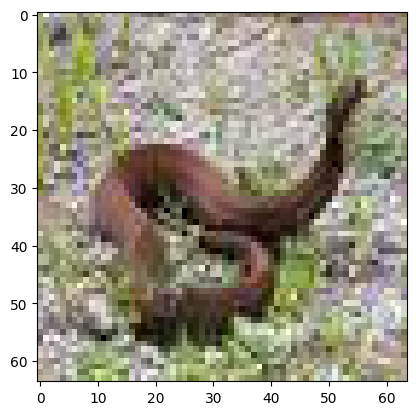

snake


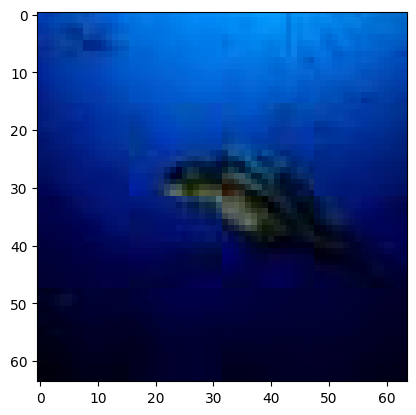

turtle


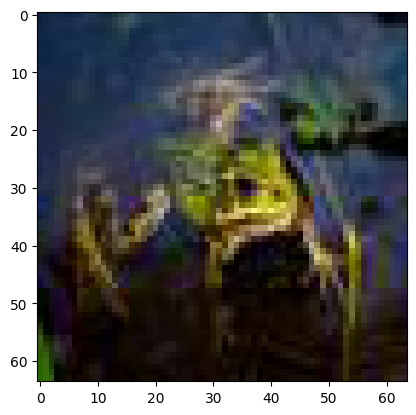

frog


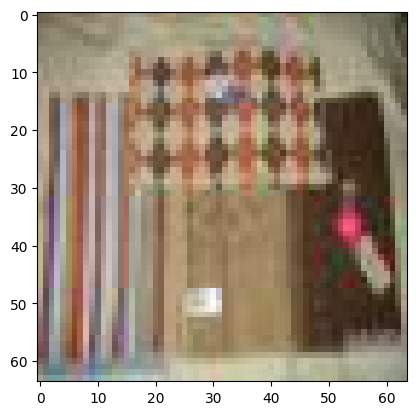

battery


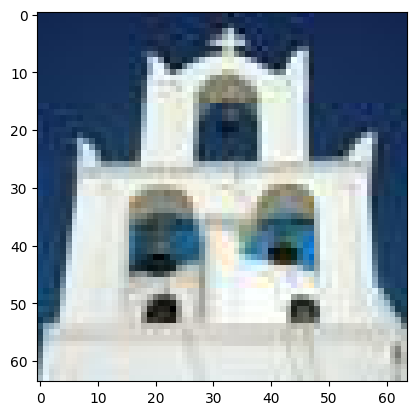

acoustic


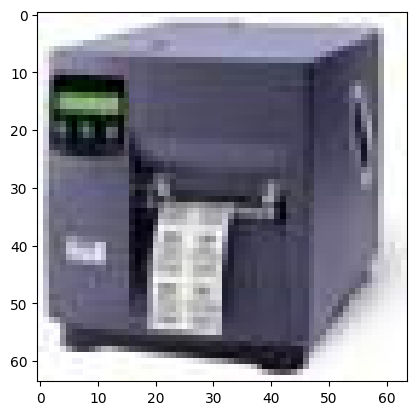

printer


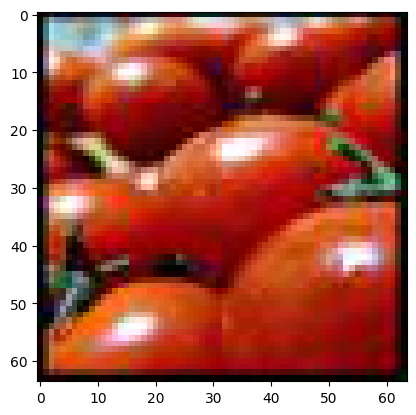

tomato


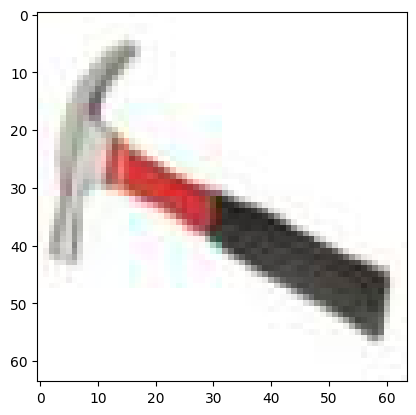

hammer


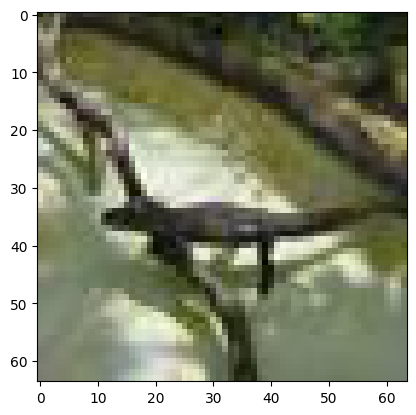

crocodilian


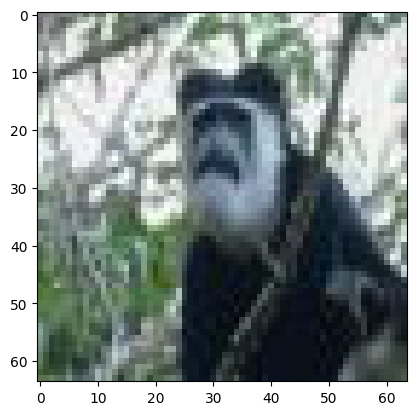

monkey


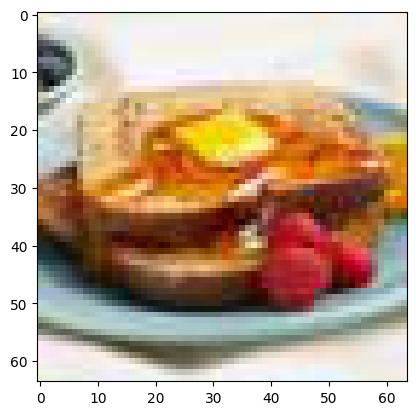

pizza


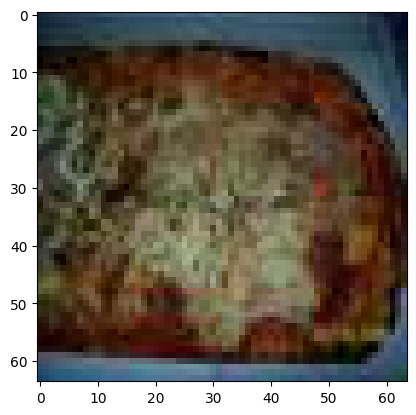

pizza


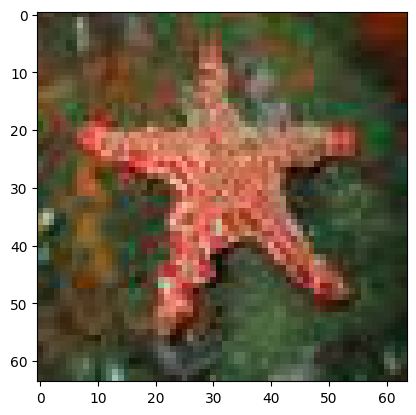

echinoderm


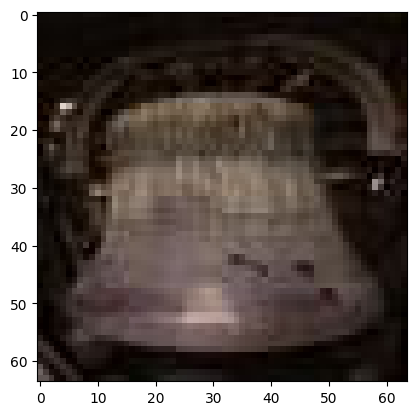

acoustic


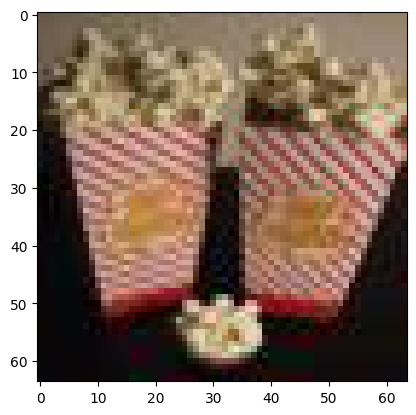

corn


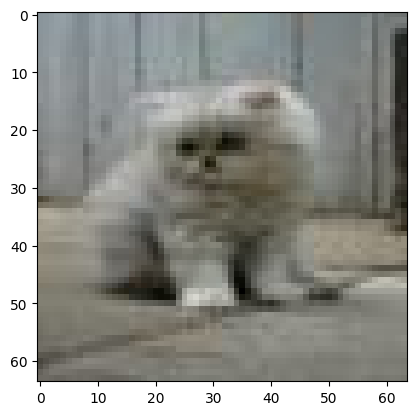

swine


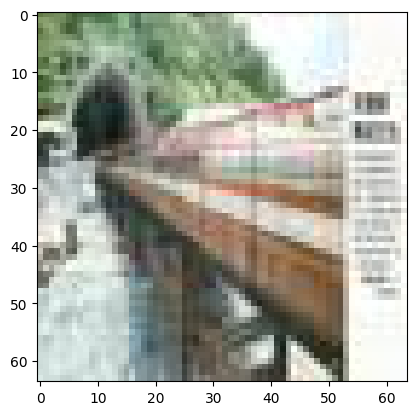

monkey


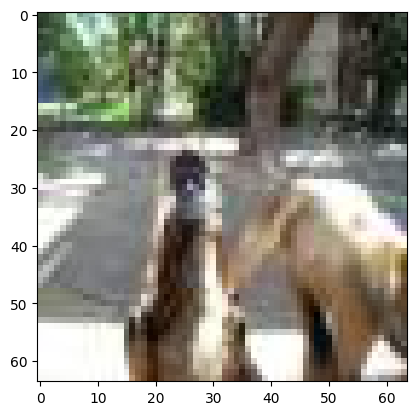

elephant


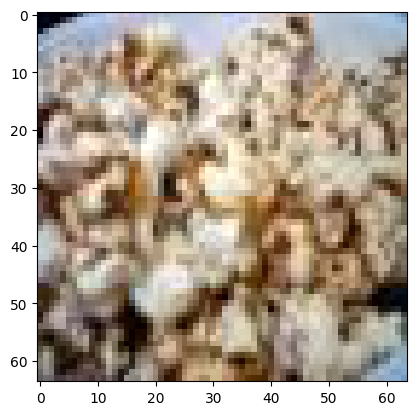

corn


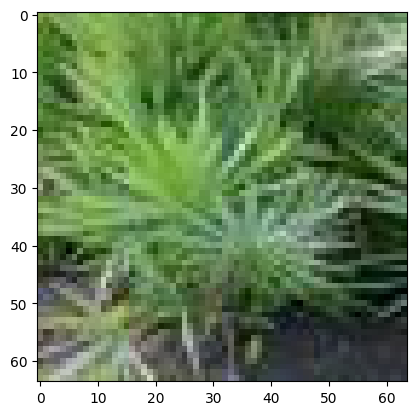

palm


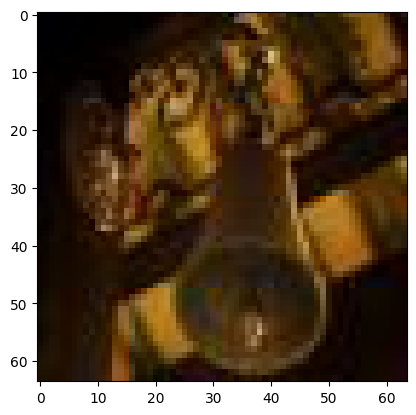

pot


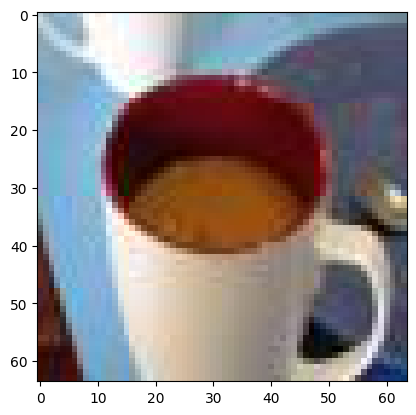

tea


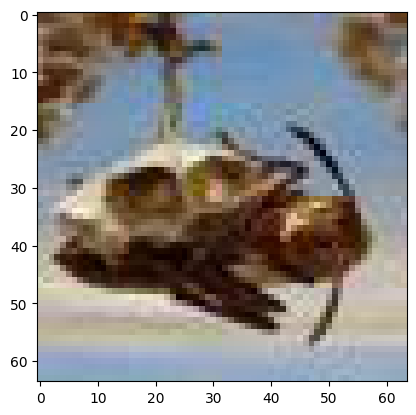

nest


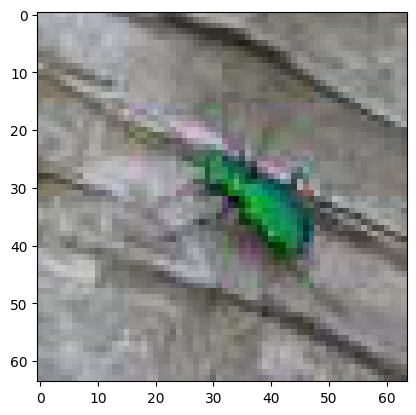

beetle


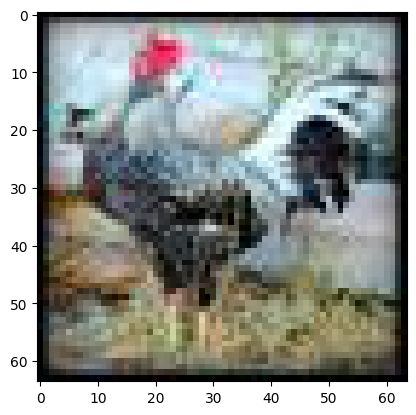

bird


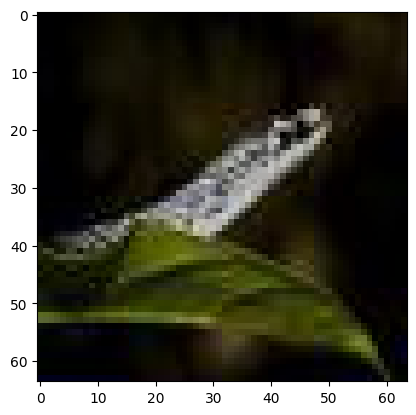

crocodilian


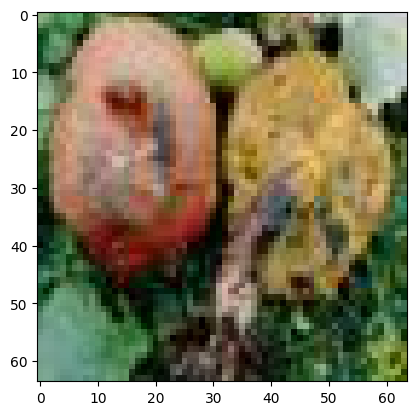

fungus


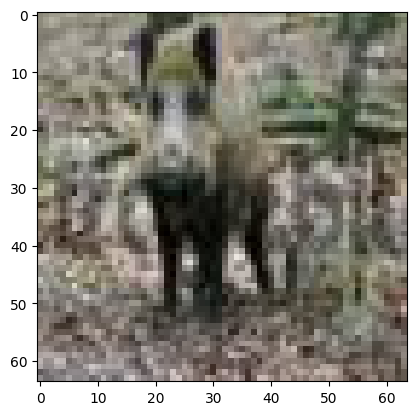

swine


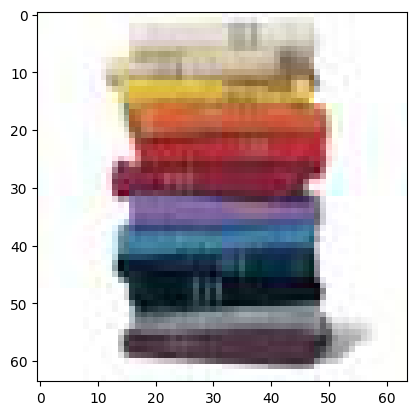

towel


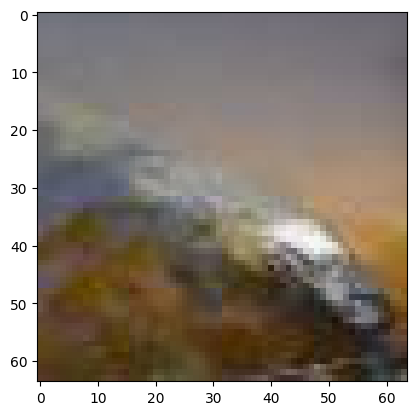

turtle


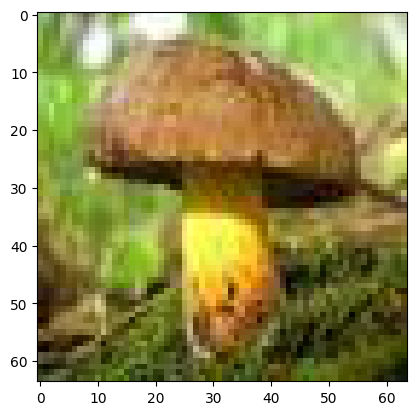

fungus


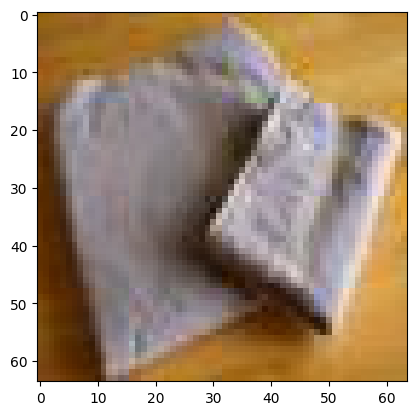

cat


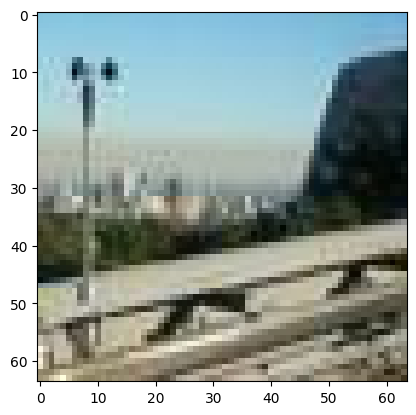

bridge


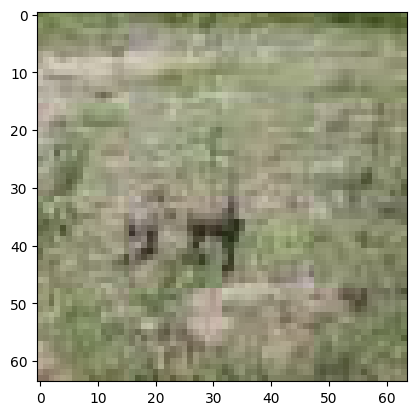

swine


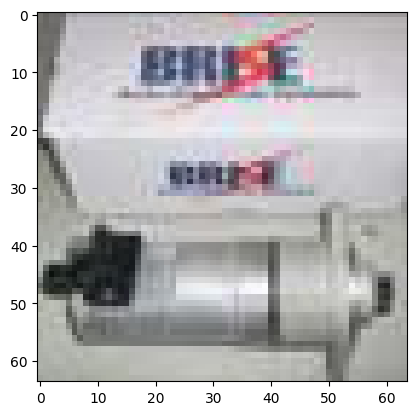

antenna


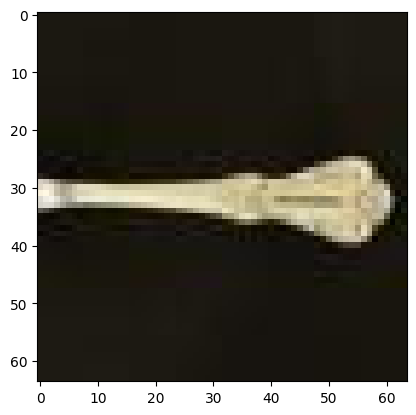

spoon


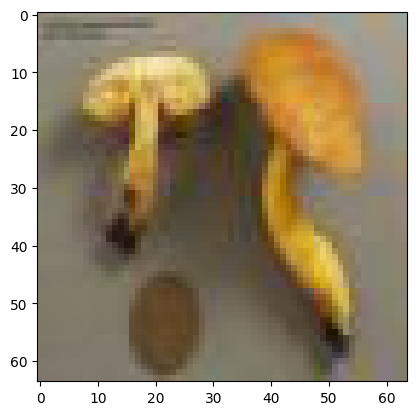

hammer


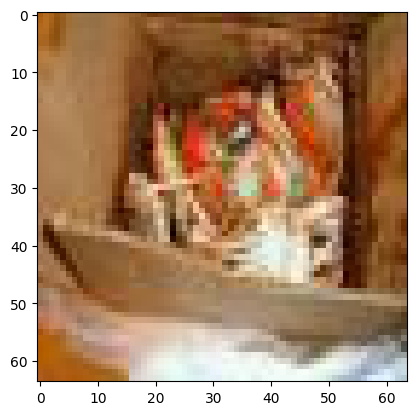

icecream


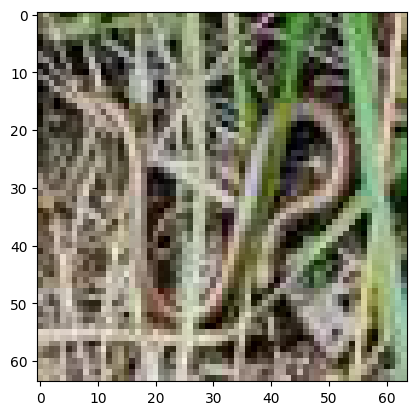

frog


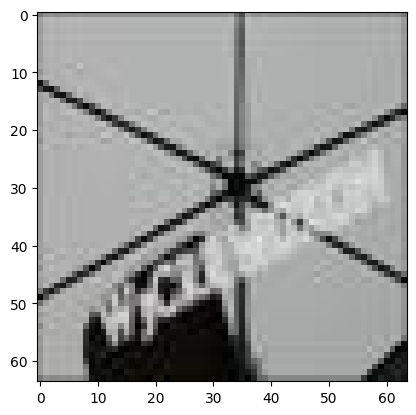

spoon


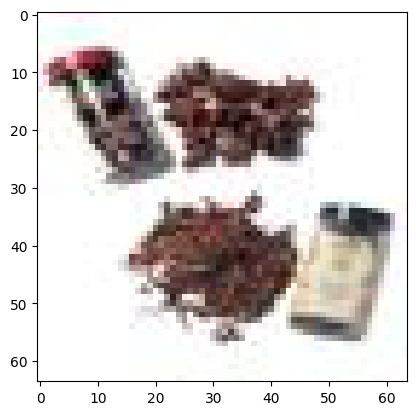

spice


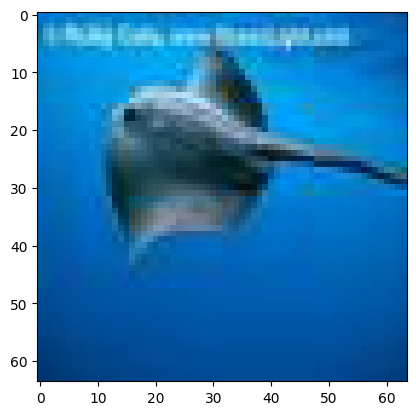

fish


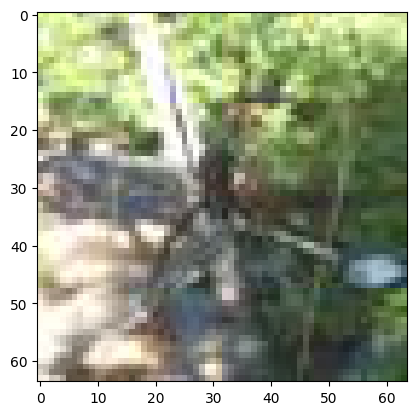

bicycle


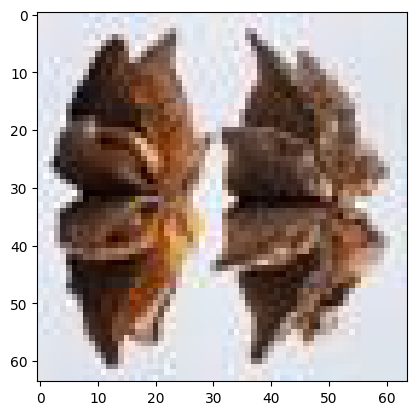

spice


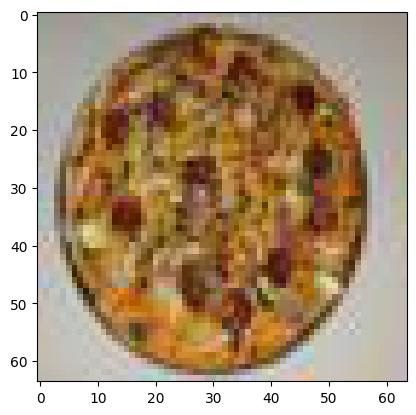

pizza


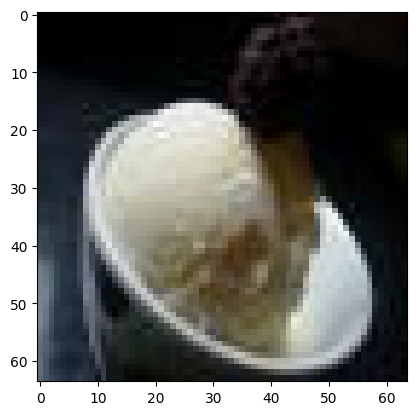

icecream


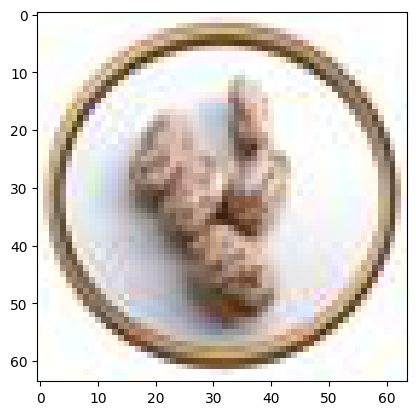

bean


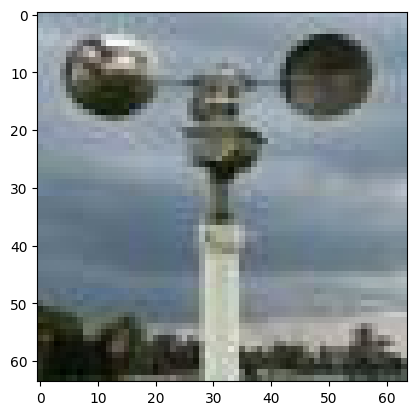

gauge


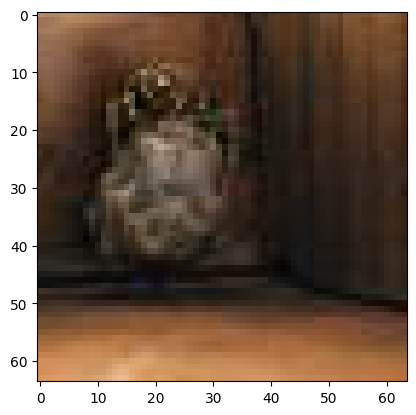

nest


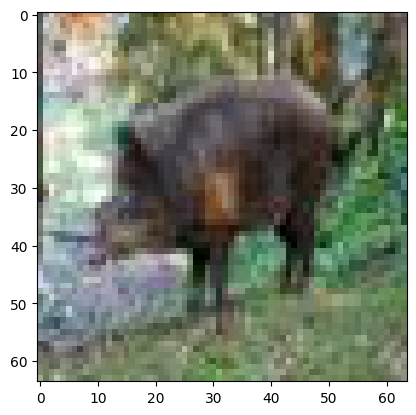

swine


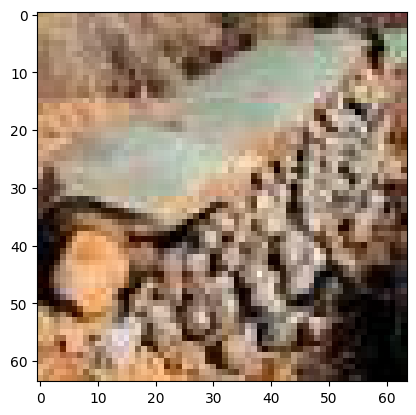

snake


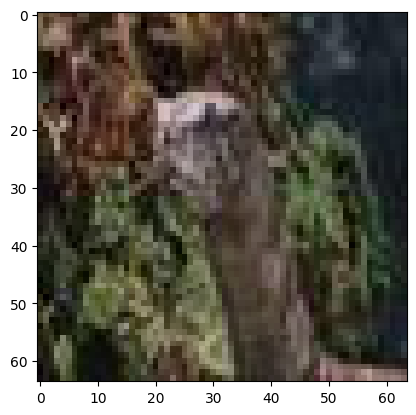

birch


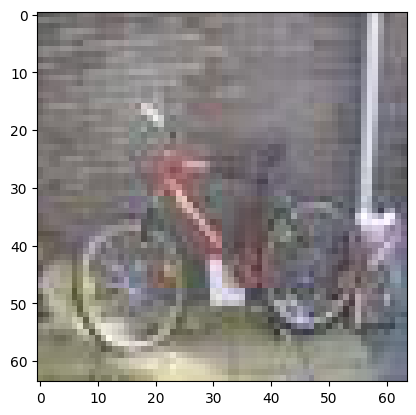

bicycle


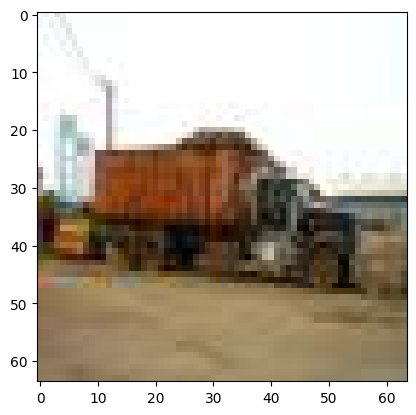

truck


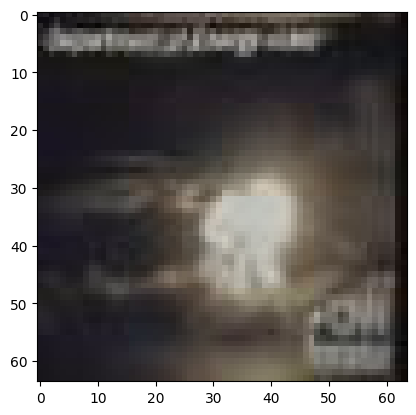

bomb


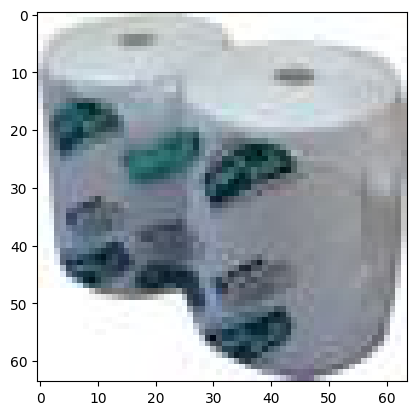

printer


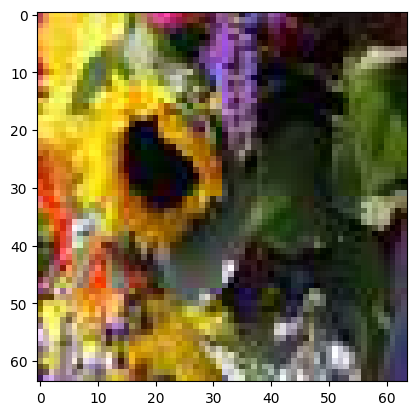

flower


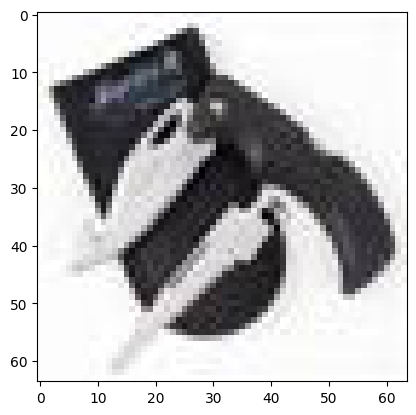

saw


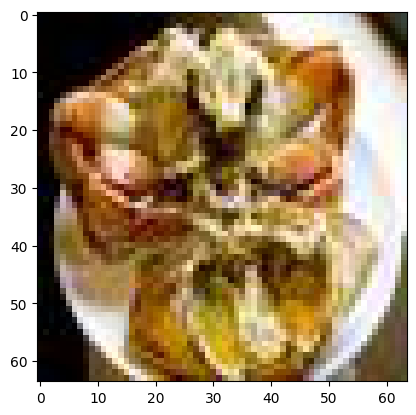

pizza


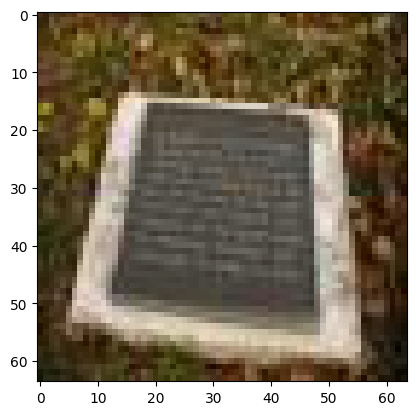

memorial


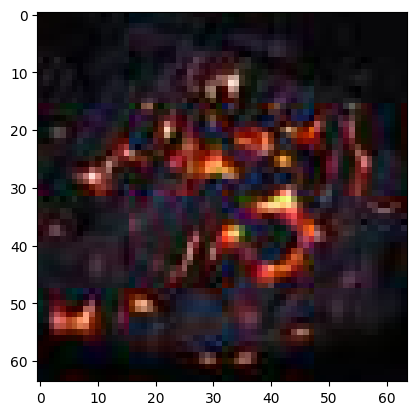

carbon


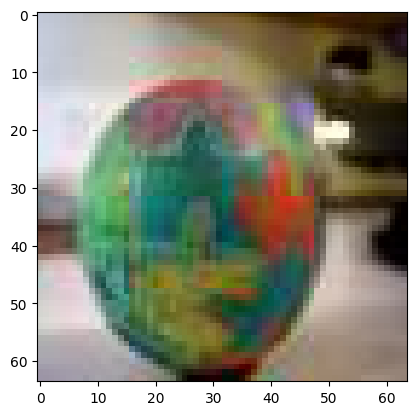

egg


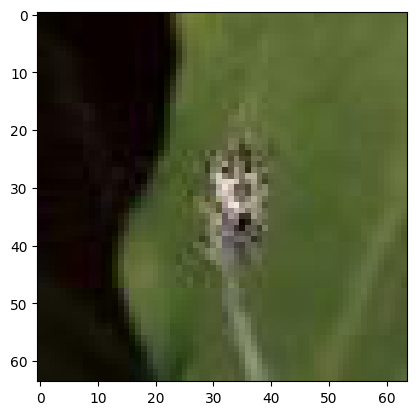

spider


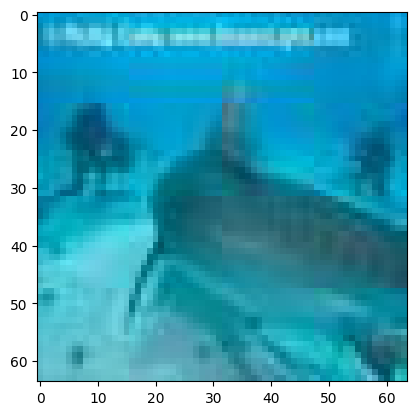

fish


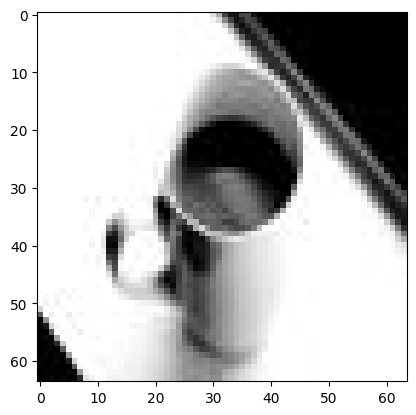

camera


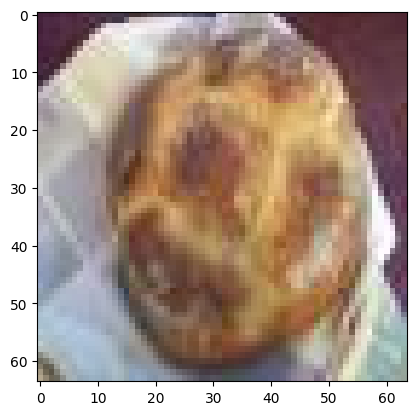

bread


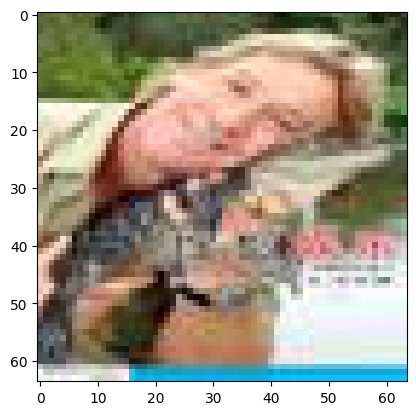

monkey


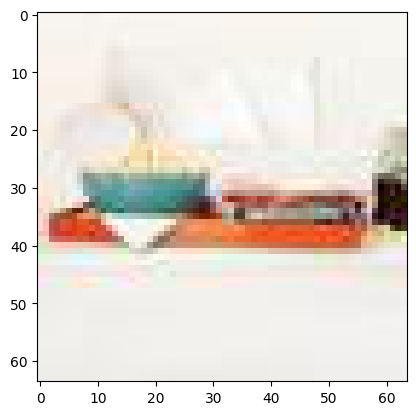

saw
0.7


In [222]:
from time import sleep

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


predict_ds = datasets.ImageFolder(root="./data/test", transform=data_normalizations)
idx_to_class = {v: k for k, v in full_ds.class_to_idx.items()}

model.eval()
ok = 0
all = 0
for img, _ in predict_ds:
    imshow(img)

    with torch.no_grad():
        preds = trainer.model(img.unsqueeze(0).to(trainer.device))
        print(idx_to_class[int(preds.argmax())])
    sleep(0.2)
    answ = input("OK?: ")

    all += 1
    if answ == "y":
        ok +=1
    if all == 100:
        print(ok/all)
        break

The model seems to be working just fine

#### Making predictions

It seems that some funny guy decided to include some black and white pictures in the evaluation set, even though all pictures in the training set had 3 channels. First lets check if there are any other surprises in our evaluation data. Maybe some pictures are in a different format, say for example YCbCr color space instead of RGB. 

In [223]:
for path in os.listdir("./data/test/test_all"):
    img = Image.open(os.path.join("./data/test/test_all", path))
    if img.mode not in ["RGB", "L"]:
        print("Yep there's more surprises")

Looks like fortunately there does not seem to be any additional trouble to deal with. Lets just hope that there weren't any in the training set as well

##### Predicting

In [218]:
from PIL import Image
import csv

preds_dicts = []
for path in os.listdir("./data/test/test_all"):
    img = Image.open(os.path.join("./data/test/test_all", path))
    if img.mode != "RGB":
        img = np.array(img)
        img = np.array((img, img, img))
        img = np.transpose(img, (1,2,0))
    img = data_normalizations(img)
    with torch.no_grad():
        preds = trainer.model(img.unsqueeze(0).to(trainer.device))
        preds_dicts.append({"path": path, "prediction": int(preds.argmax())})
    
with open("./skiers_zdziech1.csv", "w") as f:
    fieldnames = ['path', 'prediction']
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    for row in preds_dicts:
        writer.writerow(row)